# General Setup (Mapping)

In [ ]:
# Import the geopandas and geoplot libraries
!pip install geopandas
!pip install geoplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.7 MB/s eta 0:00:00


In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import seaborn as sns

# Set up the color scheme:
import mapclassify as mc

<GeoAxes: >

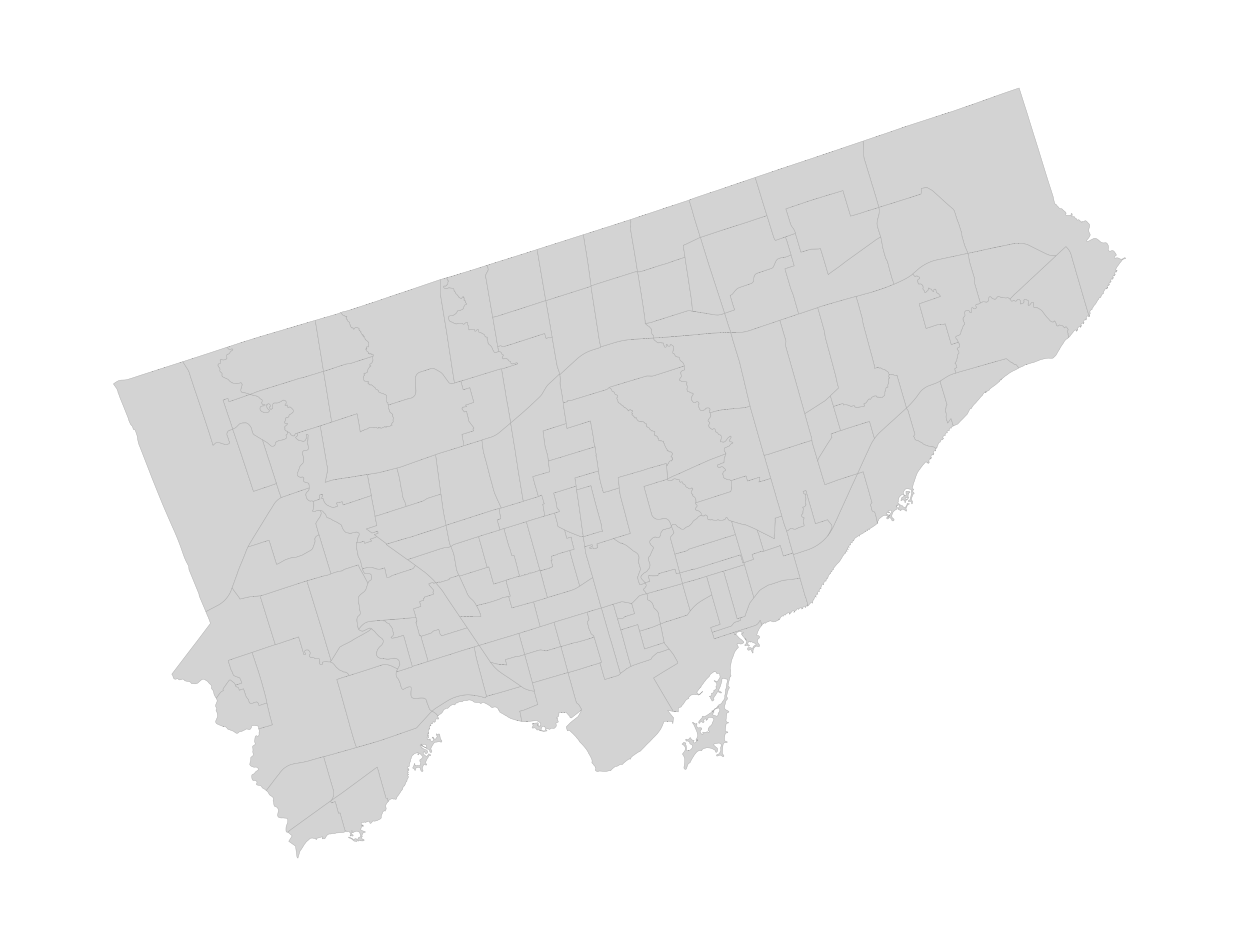

In [ ]:
# Load the json file with coordinates
geo_data = gpd.read_file("drive/My Drive/development/MachineLearning/Neighborhoods/data_in/C1_Toronto_Neighborhoods/neighbourhoods.geojson")

# Basic plot with just outlines
gplt.polyplot(
    geo_data,
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(16, 12)
)



In [ ]:
def choropleth_quick_plot(geo_data, data, left_col, right_col, display_col, colour_scheme):
  # Show the distribution
  fullData = geo_data.merge(data, left_on=[left_col], right_on=[right_col])
  #fullData.head(2)

  # Initialize the figure
  scheme = mc.Quantiles(fullData[display_col], k=20)

  # Map
  gplt.choropleth(fullData,
      projection=gcrs.AlbersEqualArea(),
      hue=display_col,
      linewidth=.1,
      figsize=(16, 12),
      scheme=scheme,
      cmap=colour_scheme,
      legend=True,
  );


# Clustering

These are libraries that are required for clustering.



## Setup (Clustering)

In [ ]:
#Libraries for Kmeans Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Libraries for Hierachical Clustering
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

We will be covering two types of clustering: Kmeans and Hierarchical clutering

## Kmeans Clustering

We will follow several steps including:
1. Loading the data
2. Standarding the data
3. Fitting singular k means
4. Fitting multiple k means
5. Selecting best number of clusters using "bent elbow" approach
6. Creating a map of clusters


In [ ]:
#import info
data = pd.read_csv("drive/My Drive/development/MachineLearning/Neighborhoods/data_in/C1_Toronto_Neighborhoods/neighbourhood.csv", encoding='utf-8')
data1 = data.drop(data.columns[[0]], axis=1)  # df.columns is zero-based pd.Index
data1 = data1.dropna()
data1.head()
#print(data1.dtypes)

,ngbd_id,ac_0_14_perc,ac_15_24_perc,ac_25_54_perc,ac_55_64_perc,ac_65_over_perc,ac_85_over_perc,edu_hc_none_perc,edu_hc_hschool_perc,edu_hc_more_perc,...,dw_age_1981_1990,dw_age_1991_2000,dw_age_2001_2005,dw_age_2006_2010,dw_age_2011_2016,labour_status_emp_rate,labour_status_unemp_rate,occ_white_collar,occ_blue_collar,occ_undef
0,0,0.14,0.12,0.44,0.12,0.15,0.02,0.16,0.24,0.16,...,0.098748,0.076955,0.052393,0.060678,0.072606,59.3,8.2,0.601092,0.367813,0.031095
1,129,0.13,0.12,0.38,0.14,0.20,0.03,0.26,0.30,0.14,...,0.213816,0.098136,0.078947,0.038377,0.004934,50.0,9.8,0.466306,0.493333,0.038919
2,128,0.13,0.14,0.41,0.13,0.17,0.02,0.20,0.30,0.15,...,0.202213,0.078672,0.020897,0.045482,0.147511,53.2,9.8,0.497510,0.460166,0.039419
3,20,0.14,0.10,0.42,0.15,0.16,0.03,0.20,0.29,0.20,...,0.042254,0.035753,0.016251,0.024919,0.026002,62.4,6.1,0.542857,0.438095,0.019048
4,95,0.07,0.12,0.48,0.11,0.19,0.03,0.06,0.16,0.10,...,0.092819,0.059580,0.044842,0.052681,0.058953,65.8,6.7,0.776071,0.204527,0.019402


In [ ]:
# standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data1)
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
count,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,...,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02
mean,-3.149569e-18,-4.960571e-16,1.618878e-15,-1.171640e-15,7.621957e-16,-7.055034e-16,-4.787345e-16,4.409396e-17,-1.133845e-16,9.763663e-17,...,3.976331e-17,8.661314e-18,1.889741e-17,-4.094440e-17,1.889741e-17,-1.007862e-16,1.984228e-16,1.196836e-16,-5.322771e-16,-2.992090e-17
std,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,...,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00
min,-1.719810e+00,-2.880375e+00,-1.990193e+00,-1.642460e+00,-3.439993e+00,-2.674885e+00,-1.989305e+00,-1.738702e+00,-2.313604e+00,-3.130065e+00,...,-1.067789e+00,-1.517531e+00,-9.956083e-01,-9.176143e-01,-7.131924e-01,-1.850666e+00,-2.019529e+00,-2.226803e+00,-1.965743e+00,-1.708414e+00
25%,-8.599050e-01,-6.924537e-01,-7.892633e-01,-6.267283e-01,-6.934527e-01,-6.498715e-01,-3.344849e-01,-7.360148e-01,-6.814931e-01,-6.265203e-01,...,-5.485145e-01,-7.408407e-01,-6.352031e-01,-6.768890e-01,-5.586083e-01,-7.067852e-01,-7.449885e-01,-8.697867e-01,-8.345266e-01,-8.599752e-01
50%,0.000000e+00,1.280166e-01,1.135631e-02,-1.914146e-01,-1.441447e-01,-1.436180e-01,-3.344849e-01,-1.093355e-01,1.345623e-01,8.877817e-02,...,-1.942616e-01,-2.599127e-01,-2.854373e-01,-3.496853e-01,-3.905038e-01,-1.039293e-01,-5.461241e-02,5.541569e-02,-4.435290e-02,-8.052845e-02
75%,8.599050e-01,6.749969e-01,4.116661e-01,5.341084e-01,4.051634e-01,6.157622e-01,4.929252e-01,5.173438e-01,9.506178e-01,8.040766e-01,...,9.380506e-02,6.187499e-01,2.581424e-01,2.570942e-01,6.270380e-02,7.771677e-01,6.888696e-01,8.480584e-01,7.654391e-01,6.931360e-01
max,1.719810e+00,3.136408e+00,5.615694e+00,4.597037e+00,2.053087e+00,2.893903e+00,4.629976e+00,2.773389e+00,1.970687e+00,1.877024e+00,...,5.807709e+00,3.190706e+00,5.532315e+00,4.042519e+00,4.177581e+00,3.621411e+00,3.344162e+00,1.908596e+00,2.146164e+00,3.080183e+00


In [ ]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=10, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

# inertia on the fitted data
print(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3983.6237410117574


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

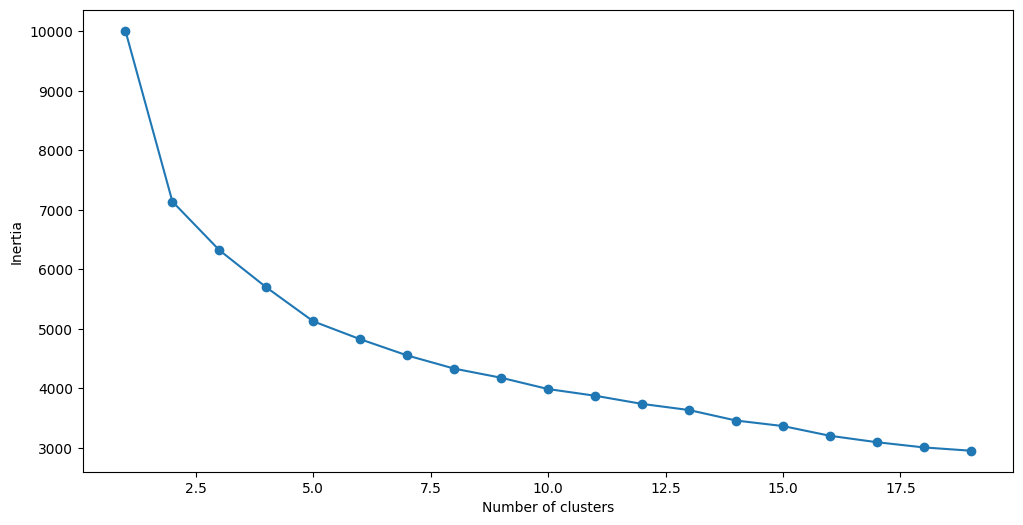

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# k means using 5 clusters and k-means++ initialization
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

#frame
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
# print(frame['cluster'].value_counts())
# print(frame)
frame.to_csv("drive/My Drive/development/MachineLearning/Neighborhoods/data_out/C1_Toronto_Neighborhoods/P1_How_are_Toronto_Neighborhoods_Clustered/cluster_frames.csv")

/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 20 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


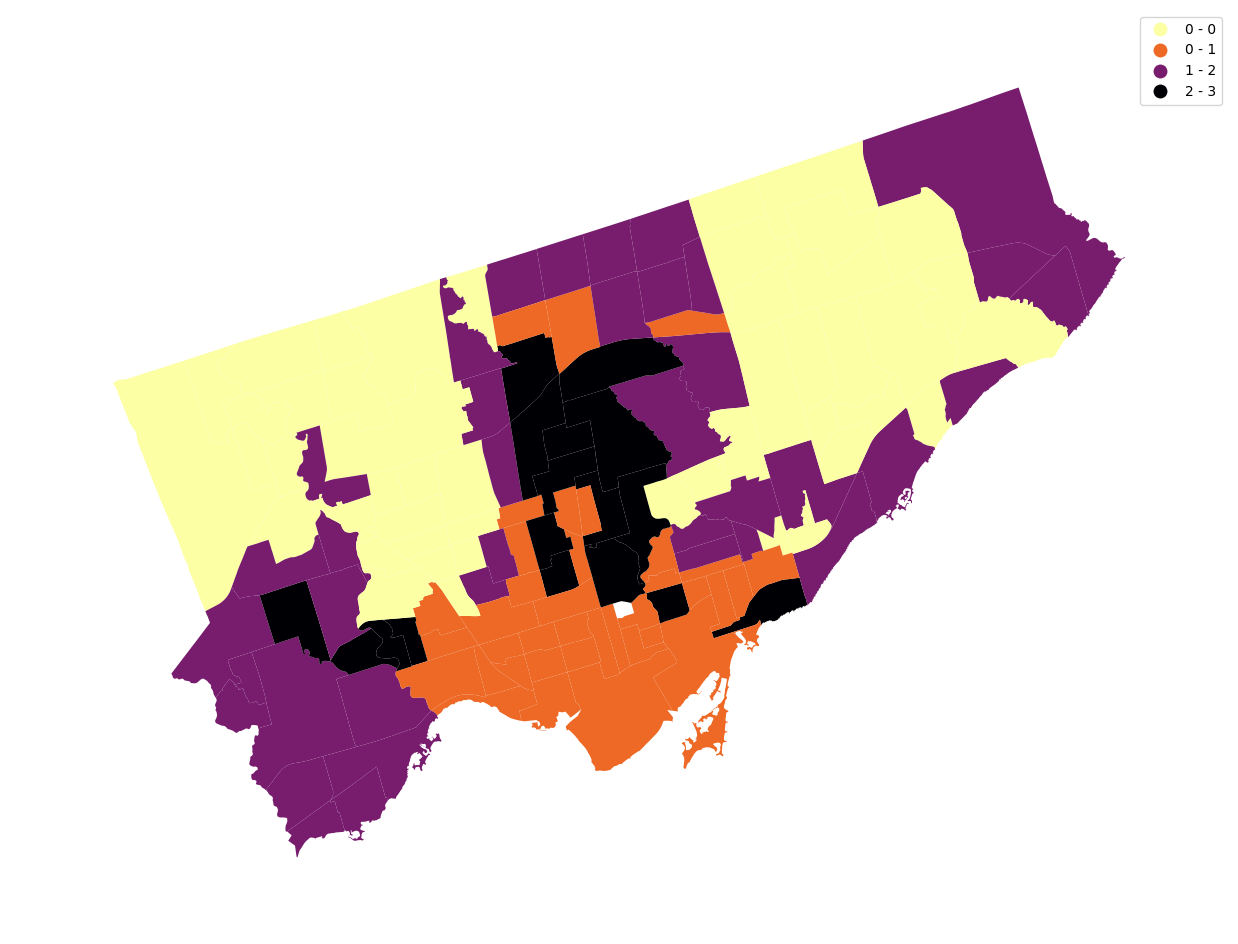

In [ ]:
# Read file
data = pd.read_csv("drive/My Drive/development/MachineLearning/Neighborhoods/data_out/C1_Toronto_Neighborhoods/P1_How_are_Toronto_Neighborhoods_Clustered/cluster_frames.csv", encoding='utf-8')
data = data.iloc[1: , :]
data  = data.dropna()

data1 = pd.read_csv("drive/My Drive/development/MachineLearning/Neighborhoods/data_in/C1_Toronto_Neighborhoods/neighbourhood.csv", encoding='utf-8')
data1 = data1.iloc[1: , :]
data['name'] = data1['name']

choropleth_quick_plot(geo_data, data, 'neighbourhood', 'name', 'cluster', 'inferno_r')

Looking at the "bent elbow" graph, I selected 4 as the optimal number of clusters. (captures mosy variance with least number of clusters). After graphing the cluster we can get a sense of the overall characteristics.
One can see the following neighbourhood characteristics:
1) areas with towers (purple)
2) areas with pre war houses (yellow)
3) areas  with early post war sfh (black)
4) areas with later post post sfh + industrial areas (orange)


## Hierarchal Clustering

We will follow several steps including:
1. Loading the data
2. Scaling the data
3. Creating a dendogram
4. Adding a cut-off threshold for the dendogram
5. Algomerative clustering
6. CheckAlgomerative clustering using sample feature


In [ ]:
#import info
data = pd.read_csv("drive/My Drive/development/MachineLearning/Neighborhoods/data_in/C1_Toronto_Neighborhoods/neighbourhood.csv", encoding='utf-8')
data.head()
data = data.drop(data.columns[[0]], axis=1)  # df.columns is zero-based pd.Index
data = data.dropna()

#scaling the data
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()


,ngbd_id,ac_0_14_perc,ac_15_24_perc,ac_25_54_perc,ac_55_64_perc,ac_65_over_perc,ac_85_over_perc,edu_hc_none_perc,edu_hc_hschool_perc,edu_hc_more_perc,...,dw_age_1981_1990,dw_age_1991_2000,dw_age_2001_2005,dw_age_2006_2010,dw_age_2011_2016,labour_status_emp_rate,labour_status_unemp_rate,occ_white_collar,occ_blue_collar,occ_undef
0,0.000000,0.000032,0.000028,0.000102,0.000028,0.000035,0.000005,0.000037,0.000055,0.000037,...,0.000023,0.000018,0.000012,0.000014,0.000017,0.013681,0.001892,0.000139,0.000085,0.000007
1,0.032812,0.000033,0.000031,0.000097,0.000036,0.000051,0.000008,0.000066,0.000076,0.000036,...,0.000054,0.000025,0.000020,0.000010,0.000001,0.012718,0.002493,0.000119,0.000125,0.000010
2,0.042144,0.000043,0.000046,0.000135,0.000043,0.000056,0.000007,0.000066,0.000099,0.000049,...,0.000067,0.000026,0.000007,0.000015,0.000049,0.017516,0.003227,0.000164,0.000152,0.000013
3,0.008211,0.000057,0.000041,0.000172,0.000062,0.000066,0.000012,0.000082,0.000119,0.000082,...,0.000017,0.000015,0.000007,0.000010,0.000011,0.025617,0.002504,0.000223,0.000180,0.000008
4,0.008745,0.000006,0.000011,0.000044,0.000010,0.000017,0.000003,0.000006,0.000015,0.000009,...,0.000009,0.000005,0.000004,0.000005,0.000005,0.006057,0.000617,0.000071,0.000019,0.000002


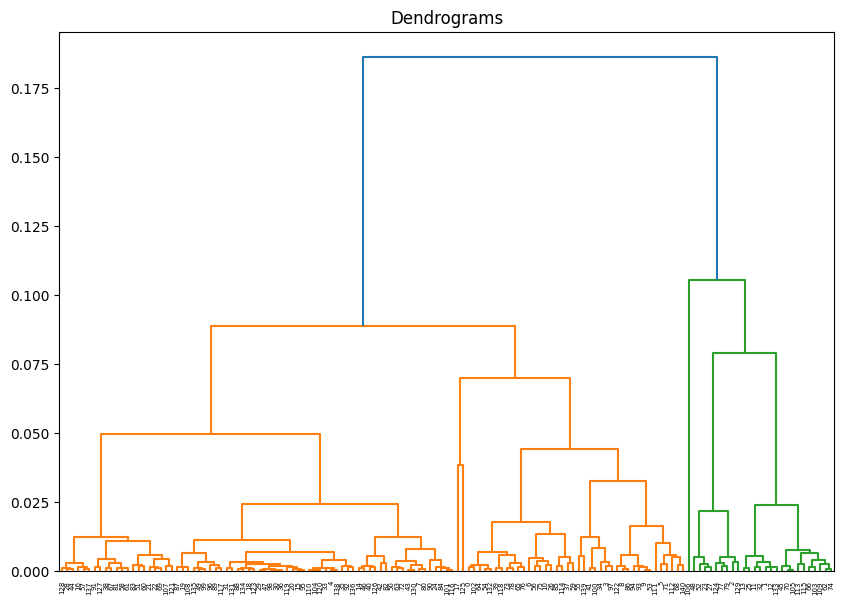

In [ ]:
#dendogram
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))


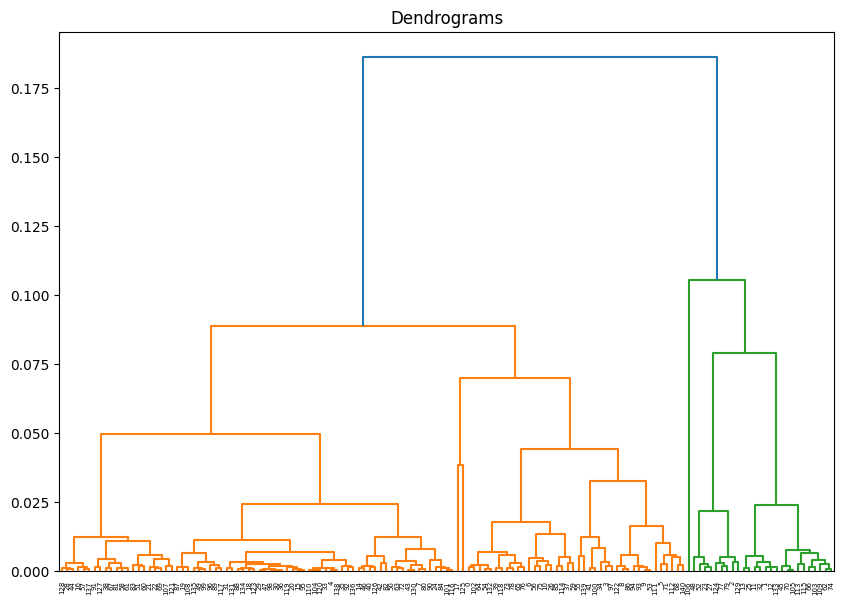

In [ ]:
#dendogram2
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')


      ngbd_id  ac_0_14_perc  ac_15_24_perc  ac_25_54_perc  ac_55_64_perc  \
0    0.000000      0.000032       0.000028       0.000102       0.000028   
1    0.032812      0.000033       0.000031       0.000097       0.000036   
2    0.042144      0.000043       0.000046       0.000135       0.000043   
3    0.008211      0.000057       0.000041       0.000172       0.000062   
4    0.008745      0.000006       0.000011       0.000044       0.000010   
..        ...           ...            ...            ...            ...   
136  0.011005      0.000014       0.000011       0.000049       0.000012   
137  0.013961      0.000021       0.000014       0.000068       0.000015   
138  0.009058      0.000008       0.000007       0.000043       0.000011   
139  0.012937      0.000067       0.000081       0.000211       0.000053   
140  0.012644      0.000053       0.000049       0.000155       0.000049   

     ac_65_over_perc  ac_85_over_perc  edu_hc_none_perc  edu_hc_hschool_perc  \
0      

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


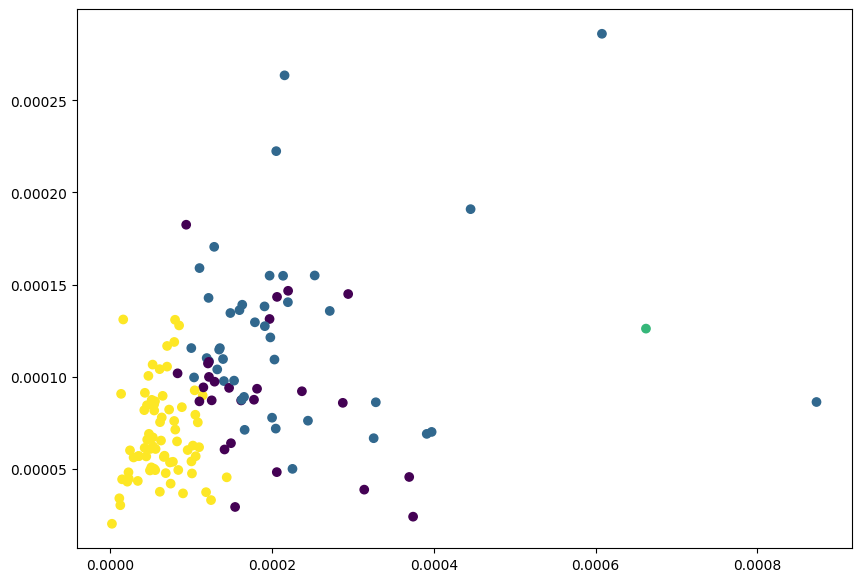

In [ ]:
#Algomerative clustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_scaled)
print(data_scaled)
plt.figure(figsize=(10, 7))
# Checking results the binary variangle: using percentage of homes rented and owned
plt.scatter(data_scaled['hou_tenure_owner_perc'], data_scaled['hou_tenure_renter_perc'], c=cluster.labels_)


Our dendogram looks as expected, the cut-off threshold determines the number of clusters in the final analysis.


Algomerative clustering was verified to work using the test with the numbers of owener and renters. The are distanctly cluster in different clusters so we know that this variable makes a difference in the analysis.
